# Getting Started With `pspec_likelihood`

In this tutorial, we will introduce how to use `pspec_likelihood` as a library. We will
cover the different classes you will interact with, how to create a data interface from
a `UVPSpec` object, and how to calculate likelihoods. 

In [1]:
from hera_pspec import UVPSpec
import numpy as np
# import hera_pspec as hp
# from collections import OrderedDict as odict
# from hera_pspec import utils
# from hera_pspec import uvpspec_utils as uvputils

from astropy import cosmology
import matplotlib.pyplot as plt
from astropy import units as un
from astropy.cosmology import units as cu

import pspec_likelihood as pl

In [3]:
path_to_uvp = '../../dvlpt/' #path to pspec files, in ./dvlpt

## The layout of the package

In `pspec_likelihood`, the idea is to be able to define a data likelihood given some
measured (or mock) power spectra. To do this, you will need to define two objects:

1. A `DataModelInterface`: An object that holds the data and theory models and knows
   how to do basic operations on them (like spherically average and apply window 
   functions).
2. A `PSpecLikelihood`: this defines the statistical likelihood based on the model
   and data. There are a number of these classes, each corresponding to a different
   set of statistical models.


## Defining the theoretical model

Our first goal is to define the theoretical model. In this tutorial, our data comes from
the H1C IDR3 *Validation* simulation, for which we know the input EoR power spectrum is
a simply power-law. We simply define a function that computes the model in the following
format:

In [4]:
def theory_model(z: float, k: np.ndarray, params: list[float]) -> np.ndarray:
    amplitude, index = params
    return k**3/(2*np.pi**2)*amplitude * un.mK**2 *(1.+z)/k ** index

Notice that the function must take exactly three parameters: the redshift, the wavenumbers
and a list of parameters. It should output an array of the same shape as `k`, representing
the $\Delta^2(k)$ values in units of ${\rm mK}^2$.

For us, this is simple. For more complicated theoretical models, for instance those that
compute entire simulations, this function may itself need to call some other functions,
whose output might not actually depend on the `k` given (i.e. the output wavenumbers 
might be set by the size of the simulation). In these cases, the theory model function
should do some kind of interpolation to yield the model at the input `k`.

## Define the `DataModelInterface`.

There are two main ways to define the main `DataModelInterface` object. You can use the 
basic class constructor, to which you need to pass all of the relevant data (power spectrum,
window function, k-bins, covariance, etc.). However, if your data is in the format of 
a PSpec object, you can simply use the `DataModelInterface.from_uvpspec` method.

First, read in the data with `UVPSpec`:

In [5]:
field = 'C'
spw = 0

filename = f'{path_to_uvp}sph_xtk_idr3_field{field}_band{spw+1}.hdf5'

# spherically averaged power spectrum
sph_pk = UVPSpec()
sph_pk.read_hdf5(filename)

In [6]:
dmi = pl.DataModelInterface.from_uvpspec(
    uvp=sph_pk,
    set_negative_to_zero = False,
    theory_uses_spherical_k = True,
    theory_model=theory_model,
    theory_uses_little_h = True,
)

In the above, we do two main things: set the data by giving the `UVPSpec` object, and 
set the theory via the `theory_model` parameter. There are many other parameters that
can be given, and we will talk about some of them later. A few deal with how the theory
function behaves (eg. whether the theory function expects wavenumbers to be given in 
units with little h, and whether it *requires* spherical k values). We can also pass a 
cosmology to use.

Another parameter that can be passed is a `sys_model` that computes bias from systematics,
given some parameters. Here, we do not use an explicit systematic model. 

Now that we have the object, we can plot both the data itself and a model: 

(100.0, 10000000.0)

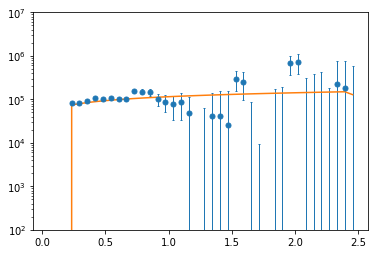

In [7]:
plt.errorbar(dmi.kpar_bins_obs.value, dmi.power_spectrum.value, yerr=np.sqrt(np.diag(dmi.covariance.value)), lw=0, marker='o', ms=5, capsize=1, capthick=1, elinewidth=1, )
plt.plot(dmi.kpar_bins_obs.value, dmi.compute_model([2e5, 2.7], []).value)
plt.yscale('log')
plt.ylim(1e2, 1e7)

Notice here that the model is computed by giving two lists of float parameters. The first
is the theory parameters, and the second are the systematics parameters (of which we have
none).

## Creating the Likelihood

Even though we have specified a model for the power spectrum itself, we have not yet
specified a statistical likelihood of the data given that model. There are a number of
different choices that can be made here. The simplest idea would be to say that the model
residuals (to both theory and systematics) are drawn from a multivariate normal 
distribution. However, if there are many different systematics parameters, sampling over
this space can become inefficient. If some of the systematics parameters are linear, then
we can do a bit better by analytically marginalizing over them. Further performance 
benefits can be gained if the covariance is assumed to be diagonal. Given all these 
considerations, we provide *different* classes for different kinds of likelihood.

Here, we will use two such likelihoods:

In [9]:
like = pl.MarginalizedLinearPositiveSystematics(model=dmi)
likeg = pl.Gaussian(model=dmi)

/home/steven/work/hera/pspec_likelihood/src/pspec_likelihood/likelihood.py:659: UserWarning: Your covariance matrix is not diagonal. The MarginalizedLinearPositiveSystematics class requires diagonal covariance. Forcing it...
  warnings.warn(


Each likelihood must be given the `DataModelInterface` object via the `model` parameter.
Some likelihoods also take other parameters, which you can find out in their documentation.

The first likelihood we defined here is the same as that used for H1C (both IDR2.1 and IDR3).
It is a likelihood in which each k-bin is assumed to have a positive systematic component
that is equally likely to be any positive number, and is not correlated with other
k-bins.

The second likelihood is the simplest multivariate Gaussian, assuming no systematics
at all (note that the assumption of no systematics is not intrinsic to the 
`Gaussian` likelihood, but rather is because we gave no `sys_model` to the `DataModelInterface`).

These likelihood classes expose one useful method: `loglike(theory_params, sys_params) -> float`, which computes the log-likelihood the data given the theory and systematic parameters.
This function is intended to be used in either Bayesian sampling or maximum-likelihood/posterior techniques to either sample the posterior or find the a point-estimate of the parameters. 

<div class="alert alert-info">
<strong>Note</strong>
<p>
We do *not* provide a sampler in `pspec_likelihood`. That is up to the user to provide.
We simply provide a method for calculating the likelihood.
</p>
</div>

In this case, we know that the "correct" values for the theory parameters are about
$A = 2e5 {\rm mK}^2$ and $\gamma=2.7$. We build an array around each of these values,
and compute the log-likelihood at each:

In [10]:
amp = np.logspace(3, 7, 100)

likes = np.zeros(amp.shape)
likes_g = np.zeros(amp.shape)

for i, a in enumerate(amp):
    likes[i] = like.loglike([a, 2.7], [])
    likes_g[i] = likeg.loglike([a, 2.7], [])
    

/home/steven/work/hera/pspec_likelihood/src/pspec_likelihood/likelihood.py:679: UserWarning: Warning: Ignoring data in positions (array([0, 1, 2]),) as the variance is zero
  warnings.warn(
/home/steven/work/hera/pspec_likelihood/src/pspec_likelihood/likelihood.py:612: UserWarning: Warning: Ignoring data in positions (array([0, 1, 2]),) as the variance is zero
  warnings.warn(
/home/steven/work/hera/pspec_likelihood/src/pspec_likelihood/likelihood.py:699: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(erf(residuals_over_errors)),


In [11]:
indx = np.linspace(1, 3, 100)

likes_indx = np.zeros(indx.shape)
likes_g_indx = np.zeros(indx.shape)

for i, a in enumerate(indx):
    likes_indx[i] = like.loglike([2e5, a], [])
    likes_g_indx[i] = likeg.loglike([2e5, a], [])

Now we can plot the resulting log-likelihoods as a function of these parameters:

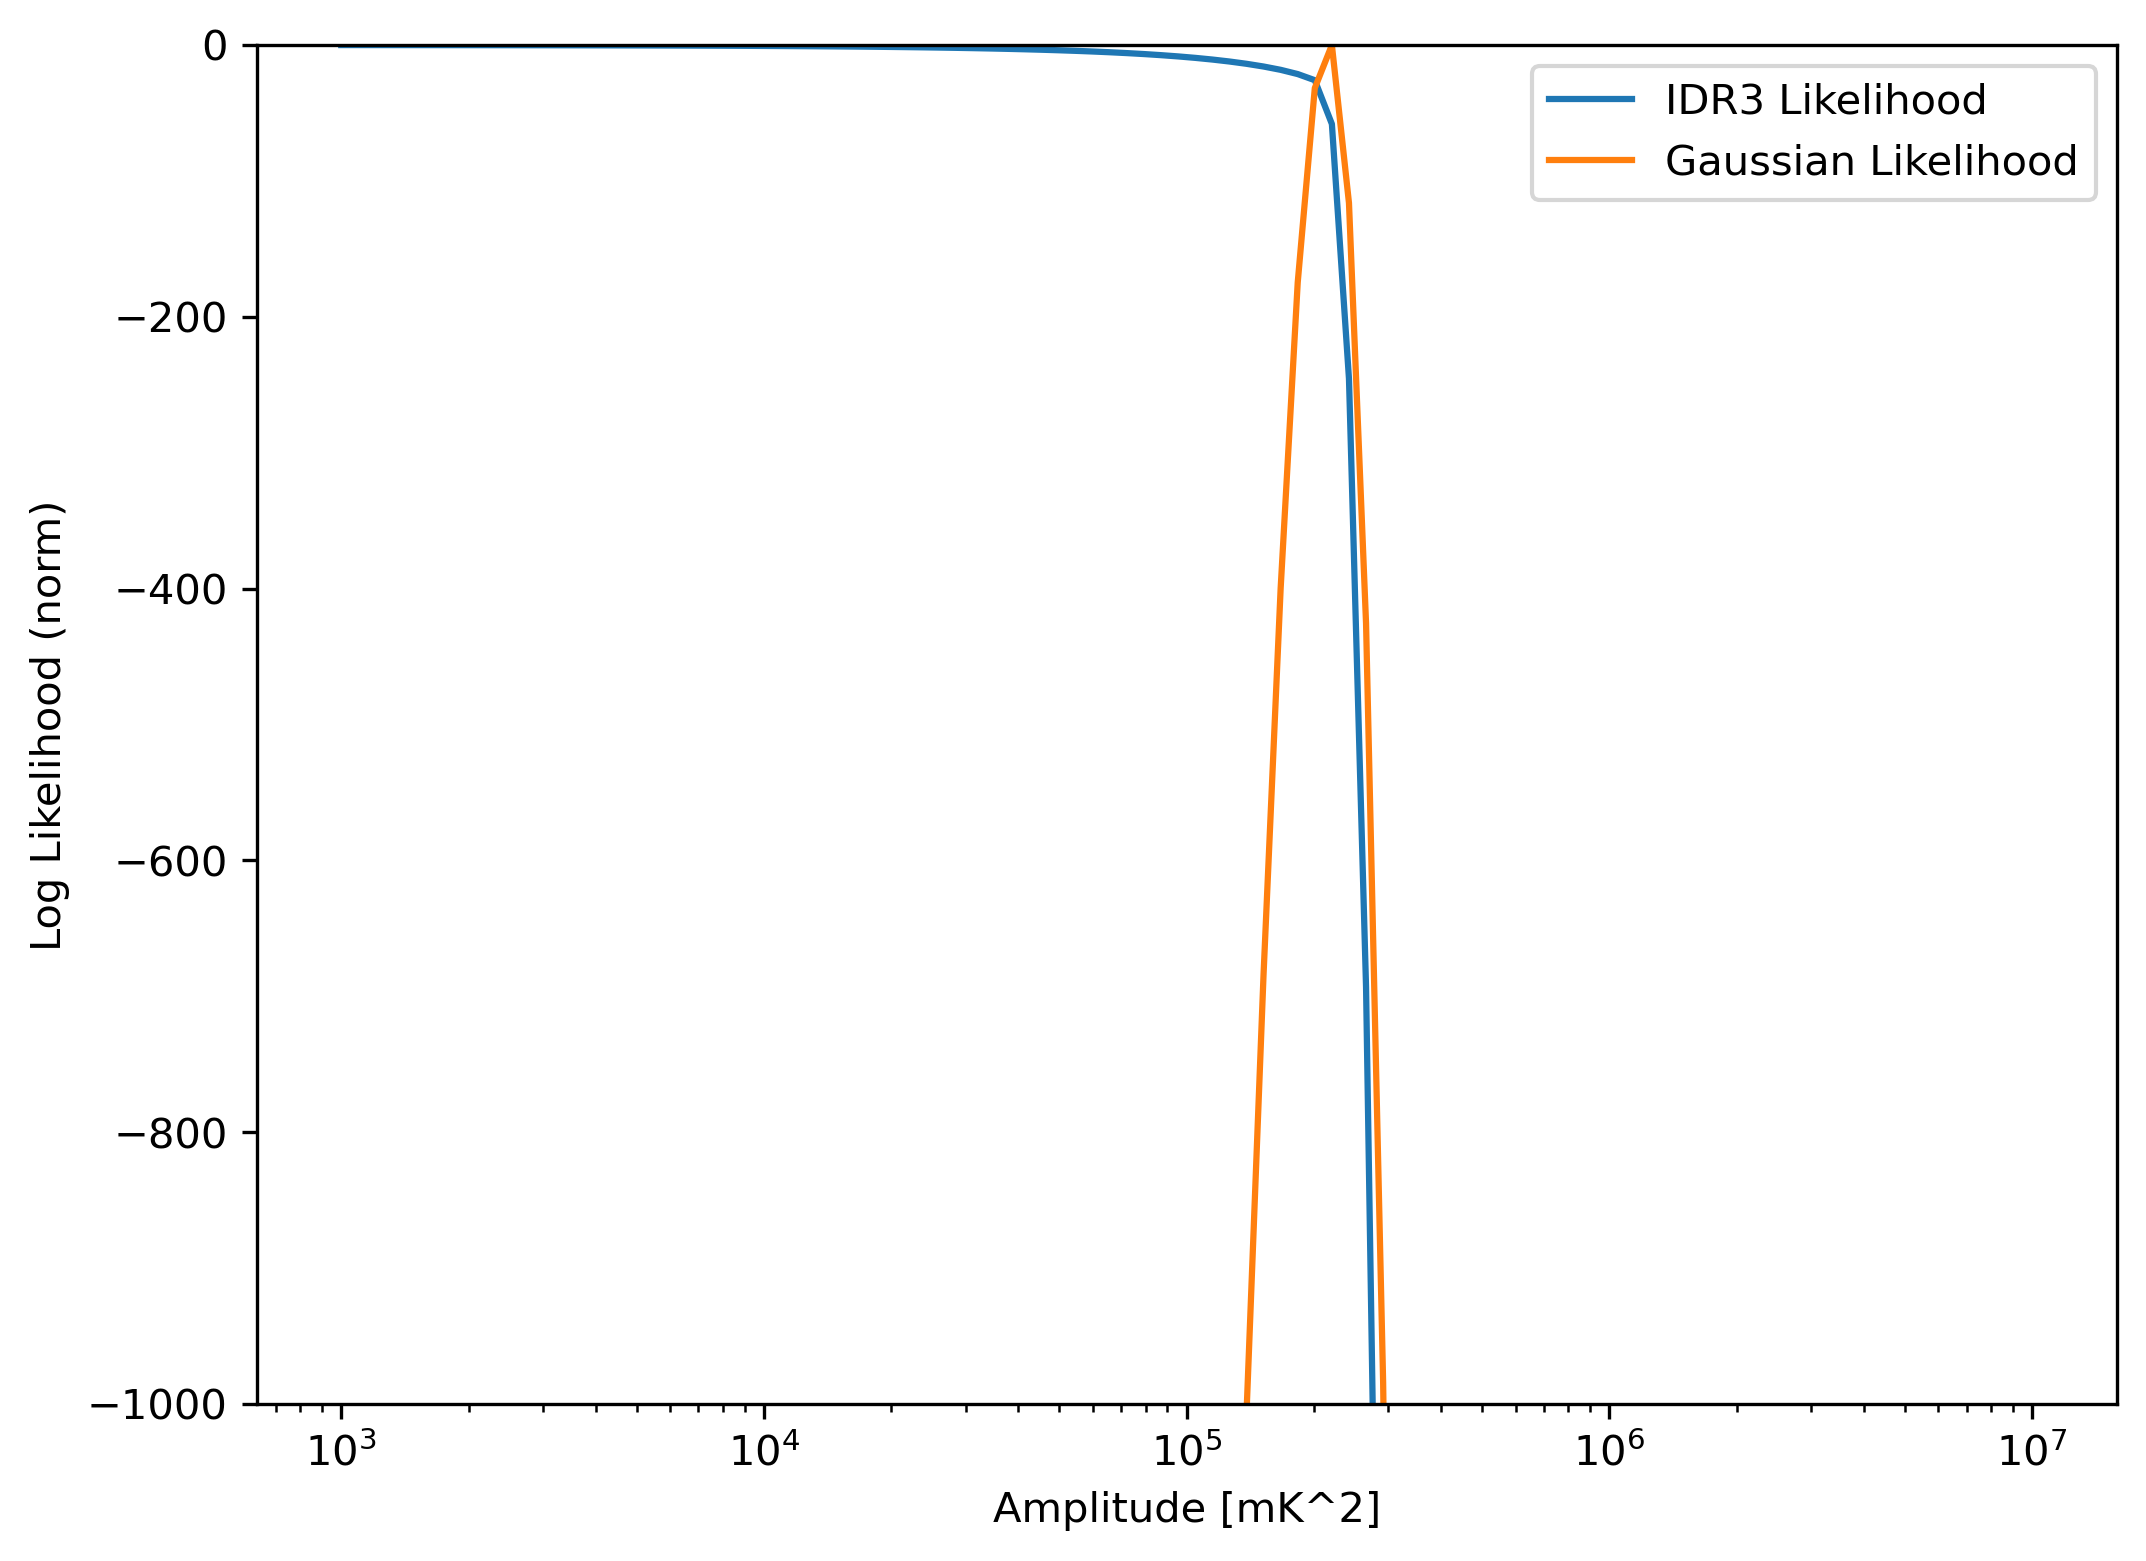

In [12]:
plt.figure(figsize=(8,6), dpi=300)
plt.plot(amp, likes - likes.max(), label='IDR3 Likelihood')
plt.plot(amp, likes_g - likes_g.max(), label='Gaussian Likelihood')
plt.xscale('log')
plt.ylim(-1000, 0)
plt.xlabel("Amplitude [mK^2]")
plt.ylabel("Log Likelihood (norm)")
plt.legend()

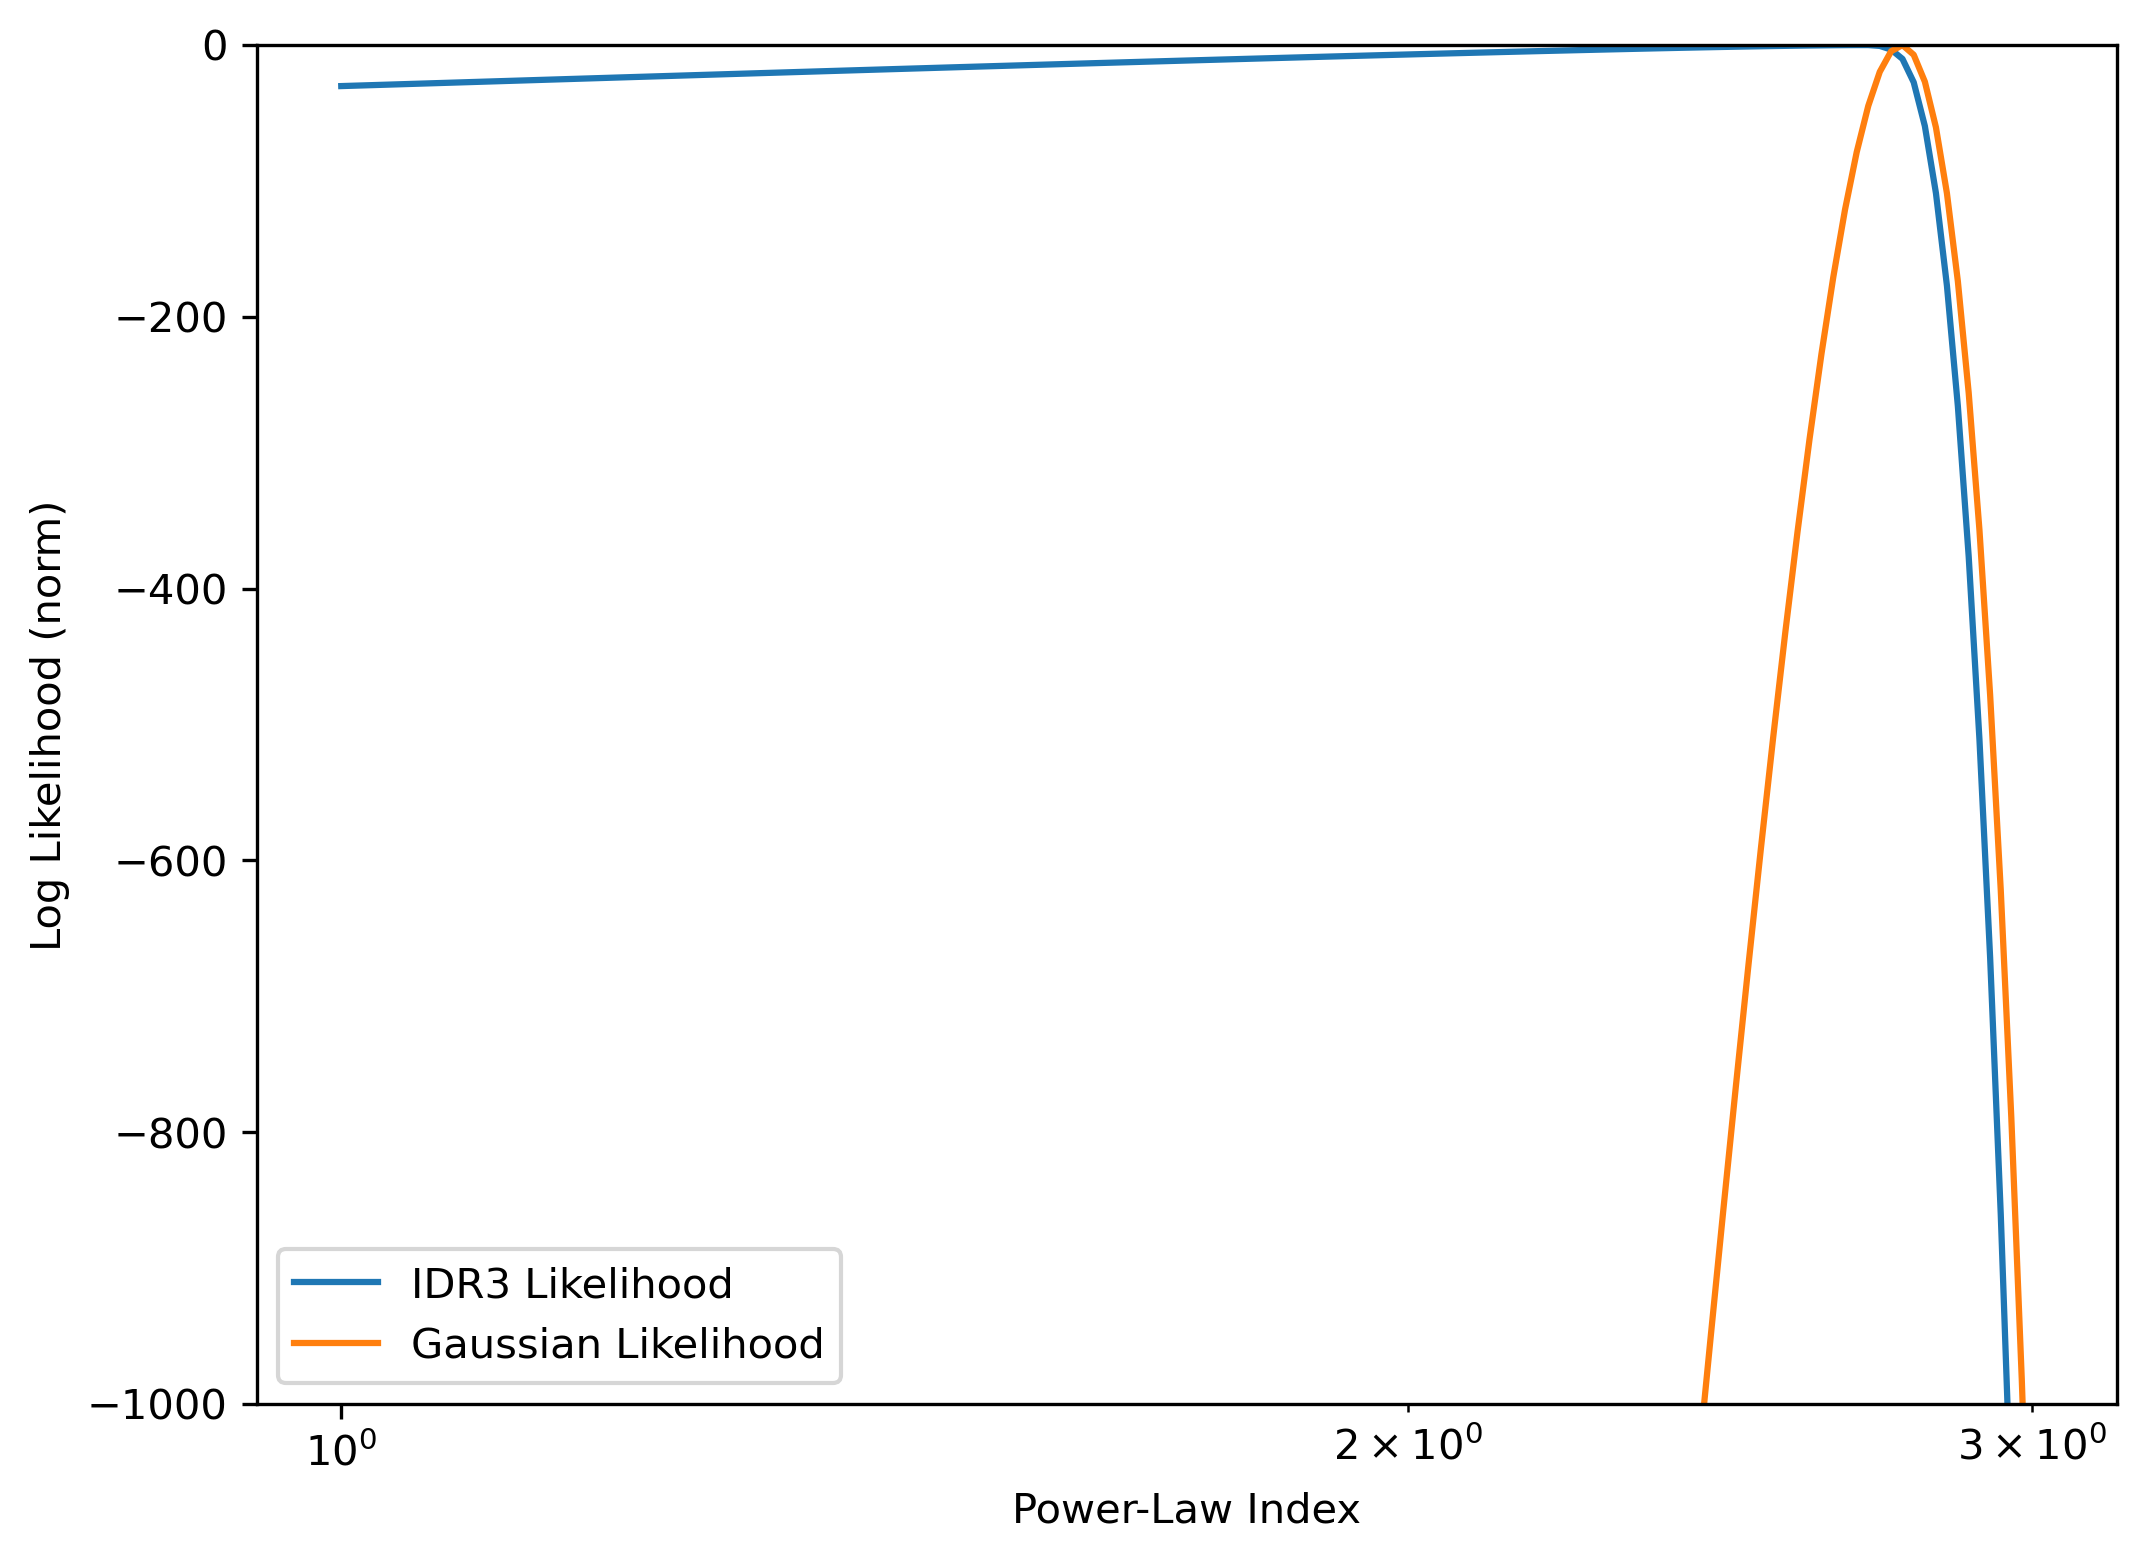

In [15]:
plt.figure(figsize=(8,6), dpi=300)
plt.plot(indx, likes_indx - likes_indx.max(), label='IDR3 Likelihood')
plt.plot(indx, likes_g_indx - likes_g_indx.max() , label='Gaussian Likelihood')
plt.xscale('log')
plt.ylim(-1000, 0)
plt.xlabel("Power-Law Index")
plt.ylabel("Log Likelihood (norm)")
plt.legend()

Clearly, the maximum likelihood is at the known correct parameters, for the `Gaussian` likelihood. For the H1C likelihood, any model which gives a power significantly lower than the data estimate has essentially equivalent likelihood value. This is because this likelihood is essentially treating the data as an upper limit by assuming the systematics may make up any portion of the power.

## Creating a `DataModelInterface` without a UVPSpec object.

If you don't have a `UVPSpec` object, you can create a `DataModelInterface` from scratch.
This makes it easier to mock up data for testing, or to read data from a different source.

In the examples below, we create `DataModelInterface` objects of three different types
with the standard constructor. Each has a different mix of whether the data is in 
spherical/cylindrical space, and whether the theory model is computed in spherical/cylindrical
space.

### Spherical Data, Spherical Theory

Let's create a mock power spectrum that is already in spherical coordinates:

In [13]:
k = np.linspace(0.01, 0.5, 100)
z = 9.0
amp, indx = 1e5, 2.7
power = k**3/(2*np.pi**2)*amp * un.mK**2 *(1.+z)/k ** indx
covariance = np.diag(k**3 * 1e5)
window_function = np.eye(len(k))

Then we can define our `DataModelInterface` like so:

In [14]:
dmi = pl.DataModelInterface(
    cosmology=cosmology.Planck18,
    redshift=z,
    power_spectrum=power,
    window_function=window_function,
    covariance=covariance*un.mK**4,
    kpar_bins_obs=k * cosmology.units.littleh / un.Mpc,
    theory_uses_little_h=True,
    theory_uses_spherical_k=True,
    theory_model=theory_model,
)

Notice here that we define `kpar_bins_obs` and not `kperp_bins_obs`. If you pass only
`kpar`, then it will be interpreted as spherical `k`.

Text(0, 0.5, 'Log Likelihood (norm)')

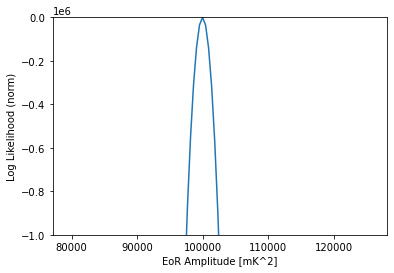

In [27]:
like = pl.Gaussian(model=dmi)
amps = np.logspace(4.9, 5.1, 101)
likes = np.array([like.loglike([a, indx], []) for a in amps])
plt.plot(amps, likes - likes.max())
plt.ylim(-1000000, 0)
plt.xlabel("EoR Amplitude [mK^2]")
plt.ylabel("Log Likelihood (norm)")

### Cylindrical Data, Spherical Theory

Suppose we have data that is in cylindrical co-ordinates. We can use this data, even
if our theory model is purely spherical. Let's create some mock power spectrum data
whose power is intrinsically only dependent on $|k|$, but which is in cylindrical 
coordinates:

In [28]:
kperp = np.linspace(0.01, 0.5, 15)
kpar = np.linspace(0.01, 0.5, 100)

KPERP, KPAR = np.meshgrid(kperp, kpar)
KPERP = KPERP.flatten()
KPAR = KPAR.flatten()
k = np.sqrt(KPAR**2 + KPERP**2)

z = 9.0
amp, indx = 1e5, 2.7
power = theory_model(z, k, [amp, indx])

covariance = np.diag(k**3 * 1e5)
window_function = np.eye(len(k))


dmi = pl.DataModelInterface(
    cosmology=cosmology.Planck18,
    redshift=z,
    power_spectrum=power,
    window_function=window_function,
    covariance=covariance*un.mK**4,
    kpar_bins_obs=KPAR * cosmology.units.littleh / un.Mpc,
    kperp_bins_obs=KPERP * cosmology.units.littleh / un.Mpc,
    theory_uses_little_h=True,
    theory_uses_spherical_k=True,
    theory_model=theory_model,
)

Note here that the theory model given is still the spherical one. However, we give both
`kperp` and `kpar`, which are arrays of the *same length* (i.e. they are not assumed
to be a rectilinear grid). 

Text(0, 0.5, 'Log Likelihood (norm)')

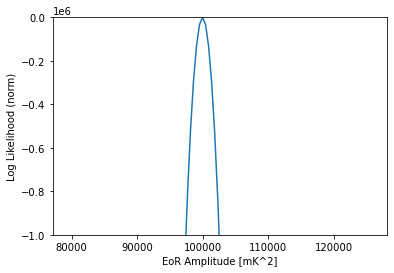

In [29]:
like = pl.Gaussian(model=dmi)
amps = np.logspace(4.9, 5.1, 101)
likes = np.array([like.loglike([a, indx], []) for a in amps])
plt.plot(amps, likes - likes.max())
plt.ylim(-1000000, 0)
plt.xlabel("EoR Amplitude [mK^2]")
plt.ylabel("Log Likelihood (norm)")

### Cylindrical Data, Cylindrical Theory

Now, if both data and theory are defined in cylindrical space, we can manage that too.
The only difference is that the theory model needs to assume that the `k` argument given
to it is really a tuple, `(kperp, kpar)`:

In [30]:
def powerlaw_eor_cylindrical(z: float, kcyl: tuple[np.ndarray, np.ndarray], params: list[float]) -> np.ndarray:
    amplitude, index = params
    kperp, kpar = kcyl
    k = np.sqrt(kperp**2 + kpar**2)
    return k**3/(2*np.pi**2)*amplitude * un.mK**2 *(1.+z)/k ** index

In [31]:
dmi = pl.DataModelInterface(
    cosmology=cosmology.Planck18,
    redshift=z,
    power_spectrum=power,
    window_function=window_function,
    covariance=covariance*un.mK**4,
    kpar_bins_obs=KPAR * cosmology.units.littleh / un.Mpc,
    kperp_bins_obs=KPERP * cosmology.units.littleh / un.Mpc,
    theory_uses_little_h=True,
    theory_uses_spherical_k=False,         # <-- this is the important bit
    theory_model=powerlaw_eor_cylindrical, # <-- this is the important bit
)

Text(0, 0.5, 'Log Likelihood (norm)')

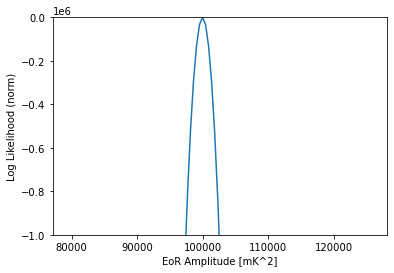

In [32]:
like = pl.Gaussian(model=dmi)
amps = np.logspace(4.9, 5.1, 101)
likes = np.array([like.loglike([a, indx], []) for a in amps])
plt.plot(amps, likes - likes.max())
plt.ylim(-1000000, 0)
plt.xlabel("EoR Amplitude [mK^2]")
plt.ylabel("Log Likelihood (norm)")